# Implementation of Benchmark Problems

from https://benchmarks.sciml.ai/html/NonStiffSDE/BasicSDEWeakWorkPrecision.html
and https://benchmarks.sciml.ai/html/NonStiffSDE/BasicSDEWorkPrecision.html

In [2]:
import torch
from torch import tensor
from math import sqrt, tan
from time import time
from matplotlib import pyplot as plt

#from google.colab import drive
#drive.mount('/content/drive/')

import sys
sys.path.append('..')
from RoughPaths import *
from RDEs import *
from ExamplePaths import *

In [3]:
def weak_error(approx_sol, exact_sol):
    return (approx_sol.mean(dim=0) - exact_sol.mean(dim=0)).abs()

def strong_error(approx_sol, exact_sol):
    return (approx_sol - exact_sol).abs().mean(dim=0)

In [4]:
def time_error_tradeoff(Ns, batch_sizes, mu, f, f_prime, x0, path, T, correct_solution, d=1, eval_points=100, device='cpu'):
    sols = {}
    for N in Ns:
        del_t_max = T/N
        print(N)
        sol = RDESolution(mu, f, 1, path, f_prime, starting_point=x0, delta_t_max=del_t_max, device=device)
        start_sample = time()
        for i in range(N+1):
          path(i/N*T)
        end_sample = time()
        print(f"\tsampled path in {end_sample - start_sample:.2f}s")
        start = time()
        sol(T, show_progress=False)
        end = time()
        print(f"\tsolution calculated in {end - start:.2f}s")
        errors_along_path = []
        for i in range(eval_points):
            u = (i+1)/eval_points * T
            approx_sol = sol(u)
            exact_sol = correct_solution(u)
            e_w = weak_error(approx_sol, exact_sol).item()
            e_s = strong_error(approx_sol, exact_sol).item()
            errors_along_path.append((e_w, e_s))
        
        sols[N] = (end-start, sum(v[0] for v in errors_along_path)/eval_points, sum(v[1] for v in errors_along_path)/eval_points, end_sample - start_sample)
        path.reset()
    return sols

def plot_tradeoff(sols, t_per_run=False):
    fig, ax = plt.subplots(2, figsize=(10,15))
    ax[0].set_title(f"Weak Error {'per run' if t_per_run else ''}")
    ax[0].set_yscale("log")
    ax[0].set_ylabel("t [s]")
    ax[0].set_xlabel("Weak Error")
    ax[0].set_xscale("log")
    ax[1].set_title(f"Strong Error {'per run' if t_per_run else ''}")
    ax[1].set_yscale("log")
    ax[1].set_xscale("log")
    ax[1].set_ylabel("t [s]")
    ax[1].set_xlabel("Strong Error")
    
    for batch_size in sols:
        ax[0].plot([v[1] for v in sols[batch_size].values()], [v[0] if not t_per_run else v[0]/batch_size for v in sols[batch_size].values()], marker='o', label=f"batch size {batch_size}")
        ax[1].plot([v[2] for v in sols[batch_size].values()], [v[0] if not t_per_run else v[0]/batch_size for v in sols[batch_size].values()], marker='o', label=f"batch size {batch_size}")
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [9]:
print(torch.cuda.device_count())
#cuda0 = torch.device('cuda:0')
#print(cuda0)

0


## Additive Noise Problem

SDE to solve is
\begin{equation} dX_{t}=\left(\frac{\beta}{\sqrt{1+t}}-\frac{1}{2\left(1+t\right)}X_{t}\right)dt+\frac{\alpha\beta}{\sqrt{1+t}}dW_{t},\thinspace\thinspace\thinspace X_{0}=\frac{1}{2},
\end{equation}
with $\alpha = \frac{1}{10}$, $\beta = \frac{1}{20}$. The correct solution is

\begin{equation}
	X_{t}=\frac{1}{\sqrt{1+t}}X_{0}+\frac{\beta}{\sqrt{1+t}}\left(t+\alpha W_{t}\right).
\end{equation}

In [10]:
alpha = .1
beta = .05
x0 = .5
T = 1.

def mu(X, t):
    # X of shape [b x 1]
    # t of shape 1
    return (beta/(1 + t).sqrt()).view(1, 1).repeat(batch_size, 1) - 1/(2 * (1 + t)) * X

def f(X, t):
    val = alpha*beta/(1 + t).sqrt()
    return val.repeat(batch_size).view(batch_size, 1, 1)

batch_sizes = [10, 100, 1000, 10000]
Ns = [100, 500, 1000, 5000, 10000]

def correct_solution(t):
    return 1/sqrt(1 + t) * x0 + beta/sqrt(1 + t) * (t + alpha * path(t)[0])

### How the Solution looks like:

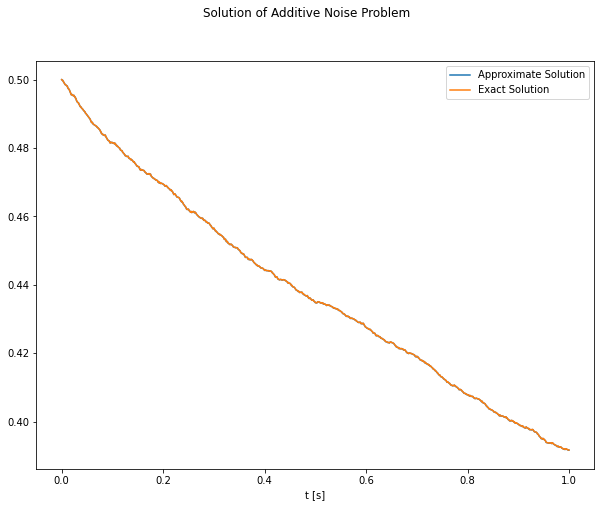

In [11]:
N = 1000
batch_size = 1
path = ItoBrownianRoughPath(1, 1)
f_prime = zeros(batch_size, 1, 1, 1)
sol = RDESolution(mu, f, 1, path, f_prime, starting_point=x0, delta_t_max=T/N)
eval_ts = [i/N for i in range(N+1)]

fig, ax = plt.subplots(figsize=(10,7.5))
fig.suptitle("Solution of Additive Noise Problem")
ax.set_xlabel("t [s]")
ax.plot(eval_ts, [sol(t)[0].item() for t in eval_ts], label="Approximate Solution")
ax.plot(eval_ts, [correct_solution(t).item() for t in eval_ts], label="Exact Solution")
ax.legend()
plt.show()

### Runtime & Error

100
	sampled path in 0.01s
	solution calculated in 0.03s
500
	sampled path in 0.03s
	solution calculated in 0.16s
1000
	sampled path in 0.07s
	solution calculated in 0.33s
5000
	sampled path in 0.45s
	solution calculated in 2.37s
10000
	sampled path in 1.21s
	solution calculated in 6.02s
100
	sampled path in 0.01s
	solution calculated in 0.03s
500
	sampled path in 0.03s
	solution calculated in 0.17s
1000
	sampled path in 0.07s
	solution calculated in 0.34s
5000
	sampled path in 0.45s
	solution calculated in 2.49s
10000
	sampled path in 1.17s
	solution calculated in 6.12s
100
	sampled path in 0.01s
	solution calculated in 0.04s
500
	sampled path in 0.04s
	solution calculated in 0.22s
1000
	sampled path in 0.09s
	solution calculated in 0.46s
5000
	sampled path in 0.58s
	solution calculated in 9.48s
10000
	sampled path in 1.48s
	solution calculated in 15.53s
100
	sampled path in 4.71s
	solution calculated in 21.77s
500
	sampled path in 25.33s
	solution calculated in 109.59s
1000
	sampled 

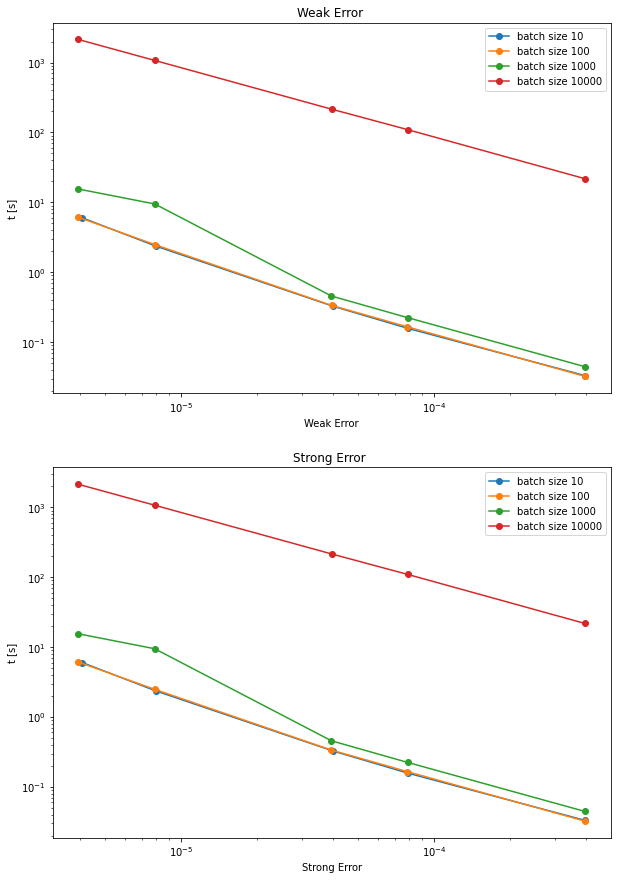

In [12]:
sols = {}
for batch_size in batch_sizes:
    f_prime = zeros(batch_size, 1, 1, 1)
    path = ItoBrownianRoughPath(1, batch_size)
    sols[batch_size] = time_error_tradeoff(Ns, batch_size, mu, f, f_prime, x0, path, T, correct_solution, d=1)
plot_tradeoff(sols)

## Scalar Noise Problem

SDE:
\begin{align*}
	dX_{t}=\alpha X_{t}dt+\beta X_{t}dW_{t},\thinspace\thinspace\thinspace X_{0}=\frac{1}{2},
\end{align*}
with $\alpha = \frac{1}{10}$, $\beta = \frac{1}{20}$. The correct solution is

\begin{align*}
	X_{t}=X_{0}e^{\left(\beta-\frac{\alpha^{2}}{2}\right)t+\alpha W_{t}}.
\end{align*}

In [ ]:
alpha = .1
beta = .05
x0 = .5
T = 1.

def mu(X, t):
    # X of shape [b x 1]
    # t of shape 1
    return alpha * X

def f(X, t):
    return beta * X.view(batch_size, 1, 1)

batch_sizes = [10, 100, 1000, 10000, 100000]
Ns = [100, 500, 1000, 5000, 10000]

def correct_solution(t):
    return x0 * ((beta - alpha**2/2) * t + alpha * path(t)[0]).exp()

### Example Solution

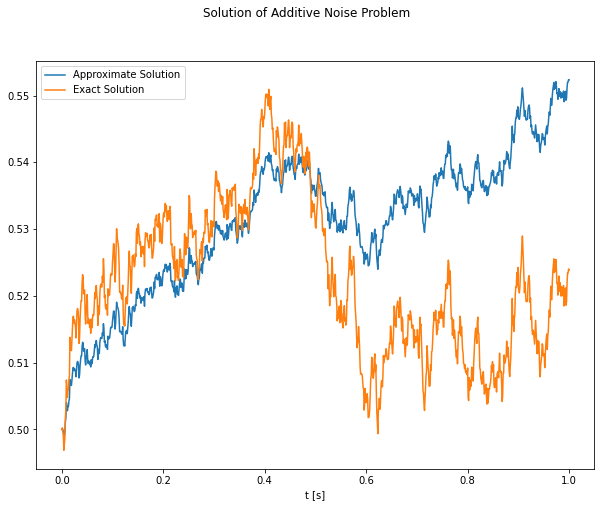

In [ ]:
N = 1000
batch_size = 1
path = ItoBrownianRoughPath(1, 1)
sol = RDESolution(mu, f, 1, path, "exact_no_grads", starting_point=x0, delta_t_max=T/N)
eval_ts = [i/N for i in range(N+1)]

fig, ax = plt.subplots(figsize=(10,7.5))
fig.suptitle("Solution of Additive Noise Problem")
ax.set_xlabel("t [s]")
ax.plot(eval_ts, [sol(t)[0].item() for t in eval_ts], label="Approximate Solution")
ax.plot(eval_ts, [correct_solution(t).item() for t in eval_ts], label="Exact Solution")
ax.legend()
plt.show()

### Runtime & Errors

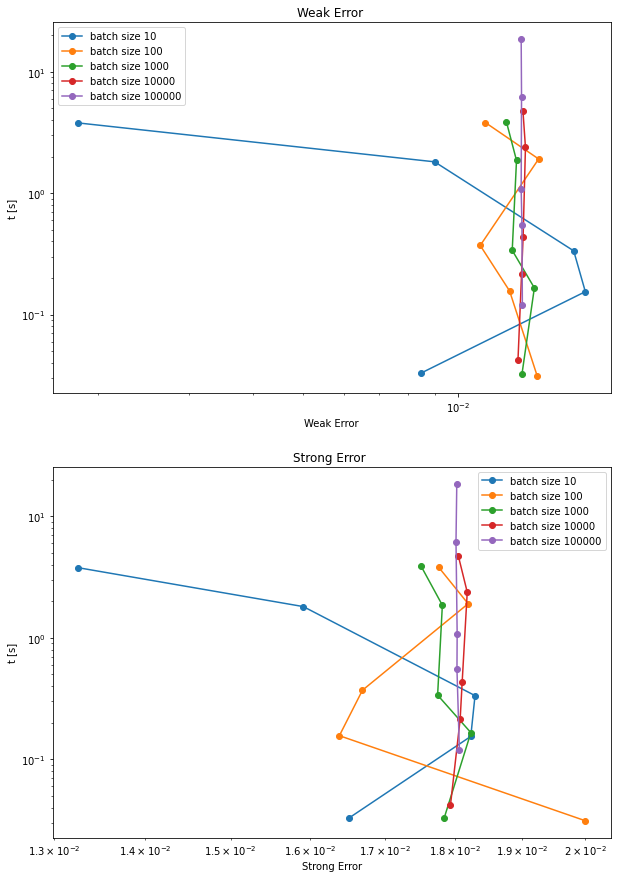

In [ ]:
sols = {}
for batch_size in batch_sizes:
    f_prime = beta * ones(batch_size, 1, 1, 1)
    path = ItoBrownianRoughPath(1, batch_size)
    sols[batch_size] = time_error_tradeoff(Ns, batch_size, mu, f, f_prime, x0, path, T, correct_solution, d=1)
plot_tradeoff(sols)

## Scalar Wave SDE

SDE:
\begin{align*}
	dX_{t}=-\left(\frac{1}{10}\right)^{2}\sin\left(X_{t}\right)\cos^{3}\left(X_{t}\right)dt+\frac{1}{10}\cos^{2}\left(X_{t}\right)dW_{t},\thinspace\thinspace\thinspace X_{0}=\frac{1}{2}.
\end{align*}
The correct solution is

\begin{align*}
	X_{t}=\arctan\left(\frac{1}{10}W_{t}+\tan\left(X_{0}\right)\right).
\end{align*}

In [ ]:
alpha = .1
x0 = .5
T = 1.

def mu(X, t):
    # X of shape [b x 1]
    # t of shape 1
    return (- alpha**2 * X.sin() * X.cos().pow(3)).view(batch_size, 1)

def f(X, t):
    return alpha * X.cos().square().view(batch_size, 1, 1)

batch_sizes = [10, 100, 1000, 10000, 100000]
Ns = [100, 500, 1000, 5000, 10000]

def correct_solution(t):
    return (alpha * path(t)[0] + tan(x0)).arctan()

def f_prime(X, t):
    return (2 * alpha * X.sin() * X.cos()).view(batch_size, 1, 1, 1)

### Example Solution

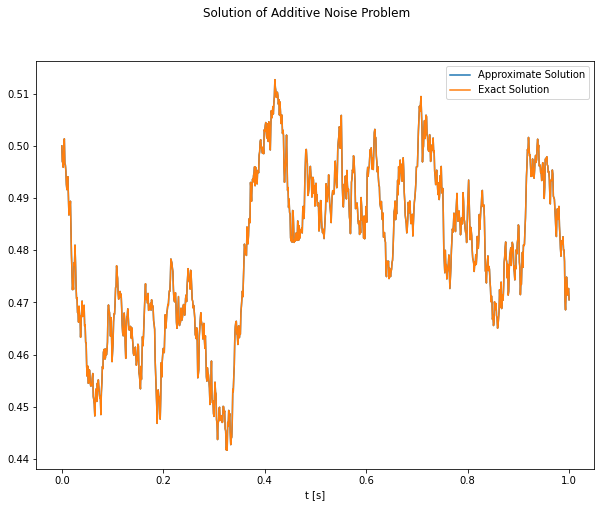

In [ ]:
N = 1000
batch_size = 1
path = ItoBrownianRoughPath(1, 1)
sol = RDESolution(mu, f, 1, path, "exact_no_grads", starting_point=x0, delta_t_max=T/N)
eval_ts = [i/N for i in range(N+1)]

fig, ax = plt.subplots(figsize=(10,7.5))
fig.suptitle("Solution of Additive Noise Problem")
ax.set_xlabel("t [s]")
ax.plot(eval_ts, [sol(t)[0].item() for t in eval_ts], label="Approximate Solution")
ax.plot(eval_ts, [correct_solution(t).item() for t in eval_ts], label="Exact Solution")
ax.legend()
plt.show()

### Runtime & Errors

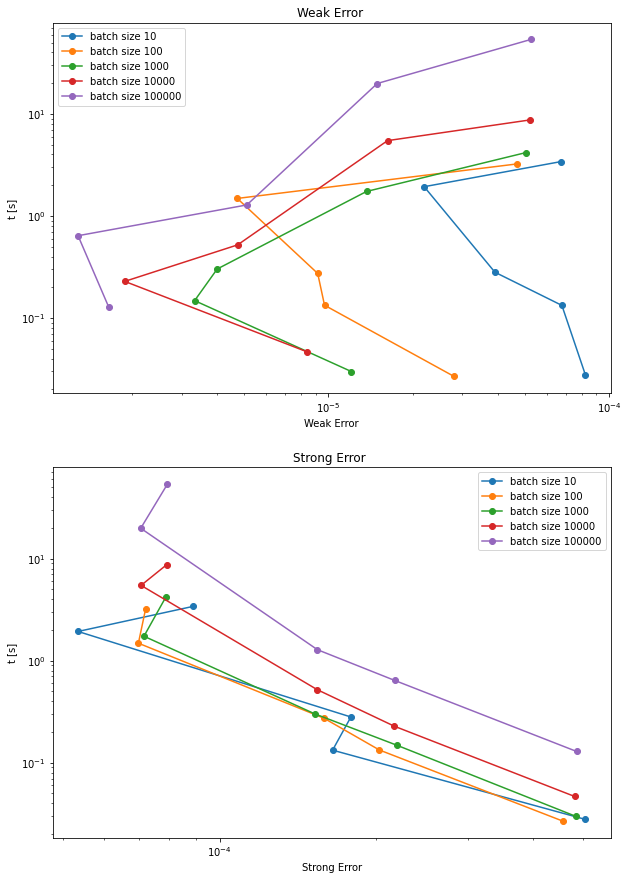

In [ ]:
sols = {}
for batch_size in batch_sizes:
    path = ItoBrownianRoughPath(1, batch_size)
    sols[batch_size] = time_error_tradeoff(Ns, batch_size, mu, f, f_prime, x0, path, T, correct_solution, d=1)
plot_tradeoff(sols)

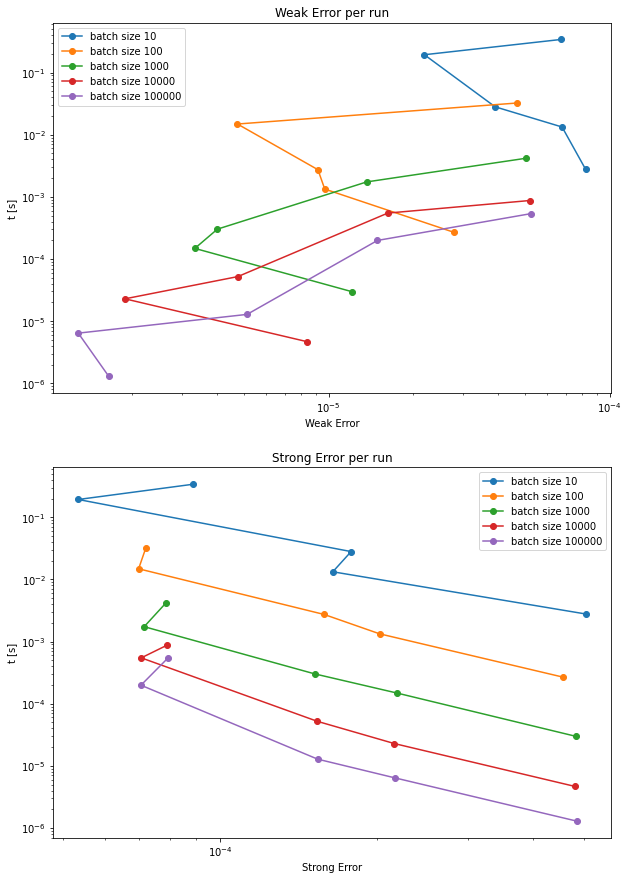

In [ ]:
plot_tradeoff(sols, True)